In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from numpy.linalg import inv
from aux import *

In [70]:
np.random.seed(42)
N=10
w_orig = np.array([-3.0, 2.0])
x = np.random.uniform(-1, 1, N)
beta = 1 # noize precision (inverse variance)
PHI =np.vstack((x,np.ones(x.shape[0]))).T # x with additional columns with ones
noize = np.random.normal(0.0, scale=1.0/np.sqrt(beta), size=N)
t = PHI@w_orig + noize # target

### Frequentists' approach

In [62]:
# x = np.append(x, -0.5)
# t = np.append(t, 0.0)
# PHI =np.vstack((x,np.ones(x.shape[0]))).T # x with additional columns with ones

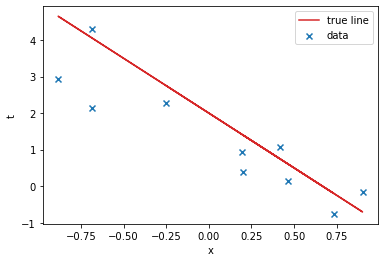

In [71]:
plt.scatter(x,t, marker="x", label="data")
plt.plot(x,PHI.dot(w_orig), c="tab:red", label="true line")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.savefig("data.png", dpi=500)
plt.show()

In [72]:
w_ml = (inv(PHI.T.dot(PHI))).dot(PHI.T.dot(t))
beta_ml = N/np.sum((t-PHI.dot(w_ml))**2)

In [29]:
    print("Original parameters:", *w_orig)
    print("Normal equation parameters:", *np.round(w_ml,2))

Original parameters: -3.0 2.0
Normal equation parameters: -2.25 1.42


In [24]:
np.abs(w_ml-w_orig)/w_orig

array([-0.25155622,  0.29085501])

In [21]:
print("Experimental noize variance: ", 1/beta_ml)

Experimental noize variance:  0.399661276225351


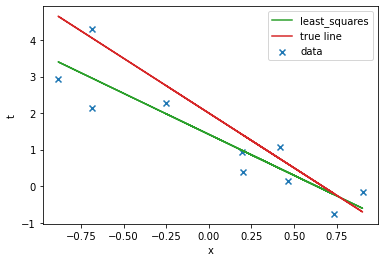

In [30]:
# plt.fill_between(np.sort(x),y1=(PHI.dot(w_ml)+stats.norm.ppf(0.975, scale=1/np.sqrt(beta_ml)))[np.argsort(x)],
#                  y2=(PHI.dot(w_ml)-stats.norm.ppf(0.975, scale=1/np.sqrt(beta_ml)))[np.argsort(x)],
#                  color="tab:red", alpha=0.3, label="95% interval")
plt.scatter(x, t, marker="x", label="data")
plt.plot(x,PHI.dot(w_ml), c="tab:green", label="least_squares")
plt.plot(x,PHI.dot(w_orig), c="tab:red", label="true line")
plt.xlabel("x")
plt.ylabel("t")
# plt.title(f"w = [{round(w_ml[0],2)},{round(w_ml[1],2)}]")
plt.legend()
# plt.savefig("../img/linreg/fited-ml.png", dpi=500)
plt.show()

#### Sequential learning

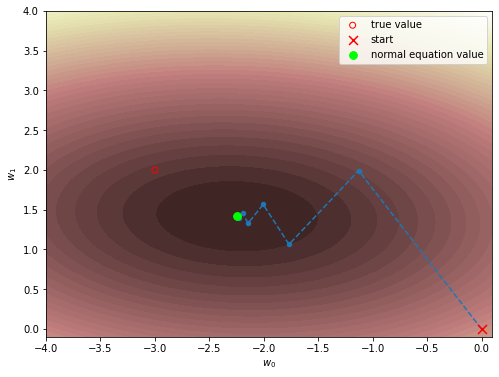

In [28]:
w0 = np.array([0.0, 0.0])[np.newaxis,:] # first guess
eta = 0.15 # learning rate

xc = np.linspace(-4,0.1, 100)
yc = np.linspace(-0.1, 4, 100)

X, Y = np.meshgrid(xc, yc)
www = np.moveaxis(np.stack((X,Y)), 0, -1)
Z = np.sum((t - www.dot(PHI.T))**2, axis=-1)

for _ in range(50):
    w0 = np.vstack((w0, w0[-1] + eta*(t-w0[-1].dot(PHI.T)).dot(PHI)))
    
plt.figure(figsize=(8,6))
plt.contourf(X, Y, Z,50, cmap='pink')
plt.scatter(*w_orig, facecolors='none', edgecolors='r', label="true value")
plt.scatter(w0[1:,0], w0[1:,1], s=20)
plt.plot(w0[:,0], w0[:,1],"--",zorder=1)
plt.scatter(*w0[0], label="start", marker='x', color='red', s=80,zorder=2)
plt.scatter(*w_ml, facecolors='none', c='lime',s=60, label="normal equation value",zorder=3)
plt.xlabel("$w_0$")
plt.ylabel("$w_1$")
plt.legend()
# plt.savefig("../img/linreg/descent.png", dpi=500)
plt.show()

### Bayesian approach

In [73]:
def prior(w, m0, S0):
    return stats.multivariate_normal.pdf(w,mean=m0, cov=S0)
m0 = np.array([0,0])
S0 = np.array([[10,0],[0,10]])
w0 = np.linspace(-5,5,100)
w1 = np.linspace(-5,5,100)
w=np.array([[[val0,val1] for val0 in w0] for val1 in w1])
pr = prior(w, m0, S0)

In [74]:
n=1
data_x = x
data_PHI = PHI
data_y = t

In [75]:
S1 = inv(inv(S0) + beta*data_PHI.T.dot(data_PHI))
m1 = S1.dot(inv(S0).dot(m0) + beta*data_PHI.T.dot(data_y))

In [76]:
lk = likelihood(w, data_y, data_PHI, beta)
m1, S1 = m1_S1(m0, S0, data_y, beta, data_PHI)
pr1 = prior(w, m1, S1)

[-2.18298207  1.40176135]
[[ 0.27086178 -0.01080054]
 [-0.01080054  0.09944057]]


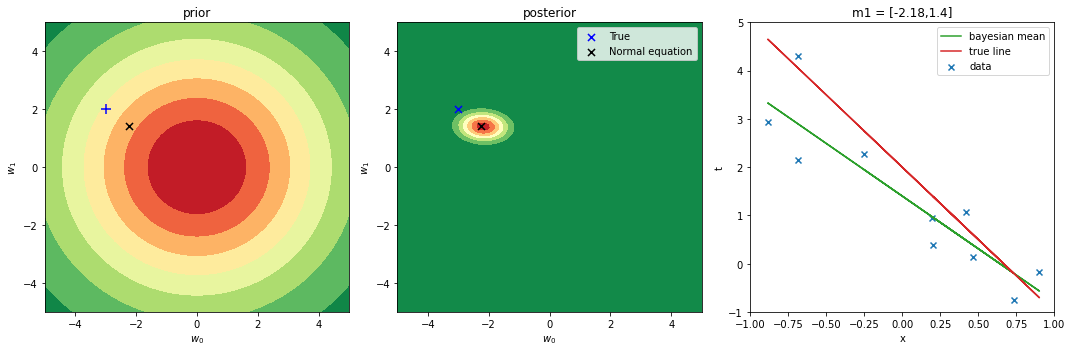

In [77]:
print(m1)
print(S1)
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.contourf(w0, w1, pr, cmap='RdYlGn_r')
plt.scatter(*w_orig, marker="+", s=100, c="b", label="true value")
plt.scatter(*w_ml, marker='x', c='black', s=50)
plt.xlabel("$w_0$")
plt.ylabel("$w_1$")
plt.title("prior")
plt.subplot(132)
plt.contourf(w0,w1,pr1, cmap='RdYlGn_r')
plt.scatter(*w_orig, marker='x', c='b', s=50, label="True")
plt.scatter(*w_ml, marker='x', c='black', s=50, label="Normal equation")
plt.legend()
plt.title("posterior")
plt.xlabel("$w_0$")
plt.ylabel("$w_1$")
plt.subplot(133)
plt.scatter(x, t, marker='x', label='data')
plt.plot(x,PHI.dot(m1), c="tab:green", label="bayesian mean")
plt.plot(x,PHI.dot(w_orig), c="tab:red", label="true line")
plt.title(f"m1 = [{round(m1[0],2)},{round(m1[1],2)}]")
plt.legend()
plt.xlabel("x")
plt.ylabel("t")
plt.xlim([-1,1])
plt.ylim([-1,5])
plt.tight_layout()
# plt.savefig("../img/linreg/bayesian_fit.png", dpi=500)
plt.show()

In [13]:
# import scipy

In [14]:
# def likelihood(w, t, PHI, beta):
#     if t.shape:
#         return np.prod(scipy.stats.norm.pdf(t,loc=w.dot(PHI.T), scale=1.0/np.sqrt(beta)), axis=-1)
#     else:
#         return scipy.stats.norm.pdf(t,loc=w.dot(PHI.T), scale=1.0/np.sqrt(beta))
    
# def m1_S1(m0, S0, y, beta, PHI):
#     if y.shape:
#         S1 = np.linalg.inv(np.linalg.inv(S0) + beta*PHI.T@PHI)
#         m1 = S1.dot(np.linalg.inv(S0).dot(m0) + beta*PHI.T.dot(y))
#     else:
#         S1 = np.linalg.inv(np.linalg.inv(S0) + beta*PHI[np.newaxis].T@PHI[np.newaxis])
#         m1 = S1.dot(np.linalg.inv(S0).dot(m0) + beta*PHI.T*y)
#     return m1, S1

# m0 = np.array([0,0])
# S0 = np.array([[10,0],[0,10]])
# w0 = np.linspace(-5,5,100)
# w1 = np.linspace(-5,5,100)
# w=np.array([[[val0,val1] for val0 in w0] for val1 in w1])
# pr = scipy.stats.multivariate_normal.pdf(w,mean=m0, cov=S0)

# lk = likelihood(w, t, PHI, beta)
# m1, S1 = m1_S1(m0, S0, t, beta, PHI)
# pr1 = scipy.stats.multivariate_normal.pdf(w,mean=m1, cov=S1)

# plt.figure(figsize=(15,5))
# plt.subplot(131)
# plt.contourf(w0, w1, pr, cmap='RdYlGn_r')
# plt.scatter(*w_orig, marker="+", s=100, c="b", label="true value")
# plt.scatter(*w_ml, marker='x', c='black', s=50)
# plt.xlabel("$w_0$")
# plt.ylabel("$w_1$")
# plt.title("prior")
# plt.subplot(132)
# plt.contourf(w0,w1,pr1, cmap='RdYlGn_r')
# plt.scatter(*w_orig, marker='x', c='b', s=50, label="True")
# plt.scatter(*w_ml, marker='x', c='black', s=50, label="Normal equation")
# plt.legend()
# plt.title("posterior")
# plt.xlabel("$w_0$")
# plt.ylabel("$w_1$")
# plt.subplot(133)
# plt.scatter(x, t, marker='x', label='data')
# plt.plot(x,PHI.dot(m1), c="tab:green", label="bayesian mean")
# plt.plot(x,PHI.dot(w_orig), c="tab:red", label="true line")
# plt.title(f"m1 = [{round(m1[0],2)},{round(m1[1],2)}]")
# plt.legend()
# plt.xlabel("x")
# plt.ylabel("t")
# plt.xlim([-1,1])
# plt.ylim([-1,5])
# plt.tight_layout()
# plt.show()

In [15]:
# m0 = np.array([0,1])
# S0 = np.array([[10,0],[0,10]])
# w0 = np.linspace(-5,5,100)
# w1 = np.linspace(-5,5,100)
# w=np.array([[[val0,val1] for val0 in w0] for val1 in w1])

# nrow=5
# fig, ax = plt.subplots(nrow, 3,figsize=(8,12))
# for i in range(nrow):
#     data_x = x[i]
#     data_PHI = PHI[i]
#     data_y = t[i]
    
#     pr = prior(w, m0, S0)
#     lk = likelihood(w, data_y, data_PHI, beta)
    
#     ax[i,0].contourf(w0, w1, lk, cmap='RdYlGn_r')
#     ax[i,0].scatter(*w_orig, marker="+", s=100, c="b", label="true value")
#     ax[i,0].set_title("Likelihood")
#     ax[i,1].contourf(w0,w1,pr, cmap='RdYlGn_r')
#     ax[i,1].scatter(*w_orig, marker='x', c='b', s=50)
#     ax[i,1].set_title("prior/posterior")
#     ax[i,2].scatter(x[:i], t[:i], marker='x')
#     ax[i,2].set_xlim([-1,1])
#     ax[i,2].set_ylim([-1,5])
#     S1 = inv(inv(S0) + beta*data_PHI[np.newaxis].T@data_PHI[np.newaxis])
#     m1 = S1.dot(inv(S0).dot(m0) + beta*data_PHI.T.dot(data_y))
#     S0, m0 = S1, m1
# fig.tight_layout()
# plt.show()

### Metropolis-Hastings

In [36]:
def posterior(w, PHI, y, beta, m0, S0):
    return likelihood(w, y, PHI, beta)*prior(w, m0, S0)

In [37]:
samples = np.array([0.0, 0.0])[np.newaxis] # initial sample point
N = 10000 # iterations
delta=0.5

In [38]:
# m1, S1 = m1_S1(m0, S0, data_y, beta, data_PHI)

In [39]:
w_0 = np.linspace(-6,1,100)
w_1 = np.linspace(-1, 5 ,100)
w=np.array([[[val0,val1] for val0 in w_0] for val1 in w_1])
pr = prior(w, m0, S0)
lk = likelihood(w, t, PHI, beta)

In [40]:
while samples.shape[0] < N:
    candidate = samples[-1]+stats.uniform.rvs(loc=-delta, scale=2*delta, size=2)
    alpha = min(1, posterior(candidate, PHI, t, beta, m0, S0)/posterior(samples[-1], PHI, t, beta, m0, S0))
    u = stats.uniform.rvs()
    if u < alpha:
        samples = np.vstack((samples, candidate))


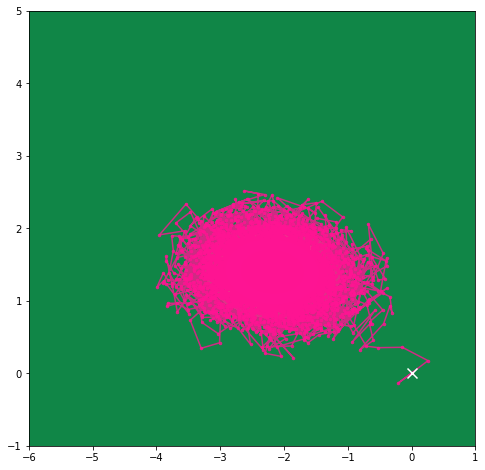

In [41]:
plt.figure(figsize=(8,8))
plt.contourf(w_0,w_1,pr*lk, cmap='RdYlGn_r')
plt.plot(samples[:,0], samples[:,1],".-", markersize=5, alpha=0.8, color="deeppink",zorder=1)
plt.xlim([-6,1])
# plt.ylim([-1,5])
plt.scatter(samples[0,0], samples[0,1],marker="x", s=100, c="white",zorder=2)
plt.show()

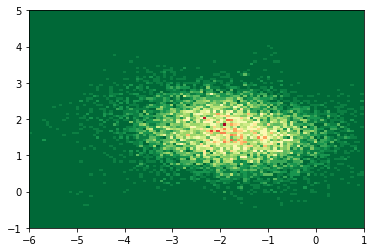

In [102]:
hist, x_edge, y_edge, _ = plt.hist2d(samples[:,0],samples[:,1], bins=100, density=True, range=[[-6,1],[-1,5]], cmap='RdYlGn_r')
# plt.close()

In [47]:
print("Mean:", np.round(np.mean(samples, axis=0),2))
print("Covariance:\n", np.round(np.cov(samples.T),2))

Mean: [-2.2  1.4]
Covariance:
 [[ 0.27 -0.02]
 [-0.02  0.1 ]]


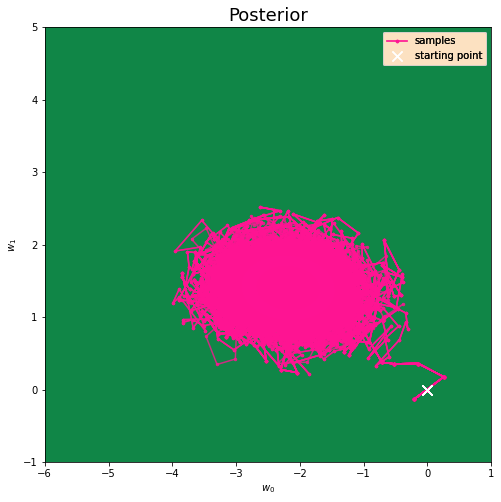

In [45]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
camera = Camera(fig)
plt.title("Posterior", fontsize=18)
plt.xlabel("$w_0$")
plt.ylabel("$w_1$")
plt.xlim([-6,1])
plt.plot(samples[:1,0], samples[:1,1],".-", markersize=5, alpha=0.8, color="deeppink", zorder=1, label="samples")
plt.scatter(samples[0,0], samples[0,1],marker="x", s=100, c="white", zorder=2, label="starting point")
plt.legend(framealpha=0.3, facecolor='bisque')
for i in np.unique(np.geomspace(1,samples.shape[0], dtype=int, num=30)):
    plt.contourf(w_0,w_1,pr*lk, cmap='RdYlGn_r')
    plt.plot(samples[:i,0], samples[:i,1],".-", markersize=5, alpha=0.8, color="deeppink", zorder=1, label="samples")
    plt.scatter(samples[0,0], samples[0,1],marker="x", s=100, c="white", zorder=2, label="starting point")
    camera.snap()
animation = camera.animate()
# plt.close()
# HTML(animation.to_html5_video())

In [46]:
animation.save("../img/linreg/anim.gif", fps=4, dpi=300)

In [96]:
print(m1)
print(S1)

[-1.88253829  1.68352639]
[[ 1.15727248 -0.13883953]
 [-0.13883953  0.40127215]]


### Predictive

In [31]:
x0 = np.linspace(-1, 1,100)
phii = np.vstack((x0,np.ones(x0.shape[0]))).T

In [32]:
m1

array([-2.26767827,  1.82093727])

In [33]:
mN = phii@m1

In [34]:
sigmaN = np.sqrt(1/beta+np.diagonal(phii@S1@(phii.T)))

In [35]:
y0 = phii@w0.T

In [36]:
mN_metropolis = y0.mean(axis=1)

In [37]:
sigmaN_metropolis = np.sqrt(y0.var(axis=1)+1/beta)

In [38]:
x0.shape

(100,)

In [39]:
mN_metropolis.shape

(100,)

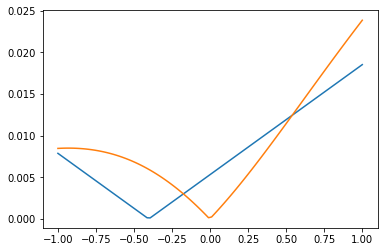

In [40]:
# plt.plot(x0, mN)
plt.plot(x0, np.abs(mN_metropolis-mN))
plt.plot(x0, np.abs(sigmaN-sigmaN_metropolis))
# plt.plot(x0, mN_metropolis+sigmaN_metropolis)

plt.show()

### Complicated prior

In [48]:
w_0 = np.linspace(-5,5,100)
w_1 = np.linspace(-5,5,100)
w=np.array([[[val0,val1] for val0 in w_0] for val1 in w_1])

In [49]:
# w_0_dist = stats.gennorm.pdf(w_0, loc=-2, scale=4, beta=0.8)
# w_1_dist = stats.gennorm.pdf(w_1, loc=0, scale=2, beta=0.9)
# pr=np.outer(w_0_dist, w_1_dist)[::-1,::-1]
def prior(w):
    return 0.5*stats.multivariate_normal.pdf(w, mean=[-2, 0], cov=[[2,0],[0, 0.9]])+\
        0.5*stats.multivariate_normal.pdf(w, mean=[-1.5, 3], cov=[[0.9,-0.0],[0.0, 1.8]])
lk = likelihood(w, t, PHI, beta)
pr = prior(w)

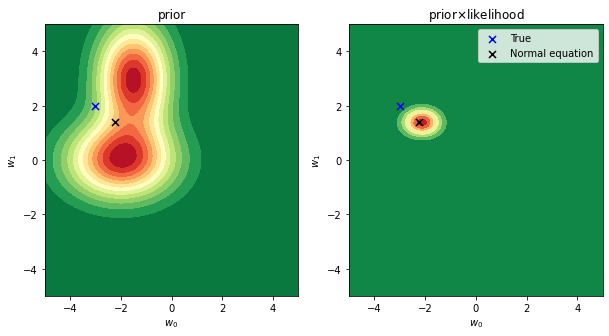

In [50]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.contourf(w_0,w_1,pr, cmap='RdYlGn_r', levels=15)
plt.scatter(*w_orig, marker='x', c='b', s=50, label="True")
plt.scatter(*w_ml, marker='x', c='black', s=50, label="Normal equation")
plt.title("prior")
plt.xlabel(r"$w_0$")
plt.ylabel(r"$w_1$")
plt.subplot(122)
plt.contourf(w_0,w_1,pr*lk, cmap='RdYlGn_r')
plt.scatter(*w_orig, marker='x', c='b', s=50, label="True")
plt.scatter(*w_ml, marker='x', c='black', s=50, label="Normal equation")
plt.legend()
plt.title(r"prior$\times$likelihood")
plt.xlabel(r"$w_0$")
plt.ylabel(r"$w_1$")
plt.savefig("../img/linreg/compl_prior.png", dpi=500)
plt.show()

In [51]:
delta=0.5
samples = np.array([0.0, 0.0])[np.newaxis]
def posterior(w, PHI, y, beta, m0, S0):
    return likelihood(w, y, PHI, beta)*prior(w)
while samples.shape[0] < N:
    candidate = samples[-1]+stats.uniform.rvs(loc=-delta, scale=2*delta, size=2)
    alpha = min(1, posterior(candidate, PHI, t, beta, m0, S0)/posterior(samples[-1], PHI, t, beta, m0, S0))
    u = stats.uniform.rvs()
    if u < alpha:
        samples = np.vstack((samples, candidate))


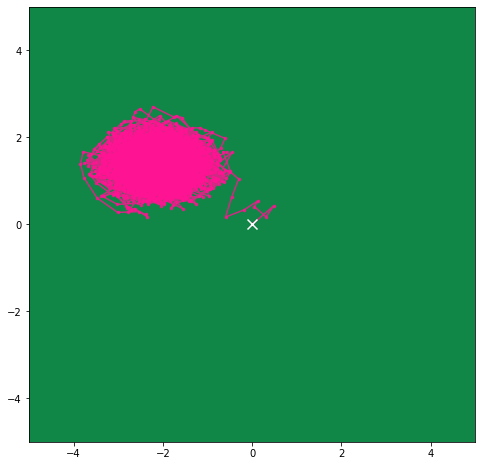

In [52]:
plt.figure(figsize=(8,8))
plt.contourf(w_0,w_1,pr*lk, cmap='RdYlGn_r')
plt.plot(samples[:,0], samples[:,1],".-", markersize=5, alpha=0.8, color="deeppink",zorder=1)
# plt.xlim([-6,1])
# plt.ylim([-1,5])
plt.scatter(samples[0,0], samples[0,1],marker="x", s=100, c="white",zorder=2)
plt.show()

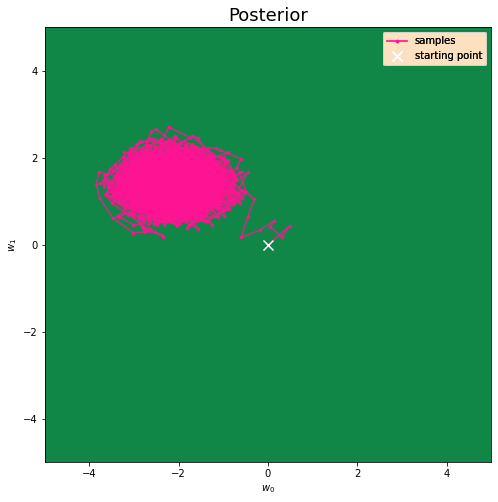

In [53]:
fig = plt.figure(figsize=(8,8))
camera = Camera(fig)
plt.title("Posterior", fontsize=18)
plt.xlabel("$w_0$")
plt.ylabel("$w_1$")
# plt.xlim([-6,1])
plt.plot(samples[:1,0], samples[:1,1],".-", markersize=5, alpha=0.8, color="deeppink", zorder=1, label="samples")
plt.scatter(samples[0,0], samples[0,1],marker="x", s=100, c="white", zorder=2, label="starting point")
plt.legend(framealpha=0.3, facecolor='bisque')
for i in np.unique(np.geomspace(1,samples.shape[0], dtype=int, num=30)):
    plt.contourf(w_0,w_1,pr*lk, cmap='RdYlGn_r')
    plt.plot(samples[:i,0], samples[:i,1],".-", markersize=5, alpha=0.8, color="deeppink", zorder=1, label="samples")
    plt.scatter(samples[0,0], samples[0,1],marker="x", s=100, c="white", zorder=2, label="starting point")
    camera.snap()
animation = camera.animate()
animation.save("../img/linreg/anim2.gif", fps=4, dpi=300)

In [353]:
print("Mean:", np.mean(samples, axis=0))
print("Covariance:\n", np.cov(samples.T))

Mean: [-1.83022425  1.64481683]
Covariance:
 [[ 0.62099147 -0.04302909]
 [-0.04302909  0.4241194 ]]


### Numerical predictive distribution

In [131]:
x0= np.array([-0.6, 0.6])
# x0= np.linspace(-0.1, 0.1, 1)
phii = np.vstack((x0,np.ones(x0.shape[0]))).T

In [132]:
w0.shape

(14810, 2)

In [196]:
W0 = np.stack((x_edge, np.roll(x_edge,-1))).mean(axis=0)[:-1]
W1 = np.stack((y_edge, np.roll(y_edge,-1))).mean(axis=0)[:-1]

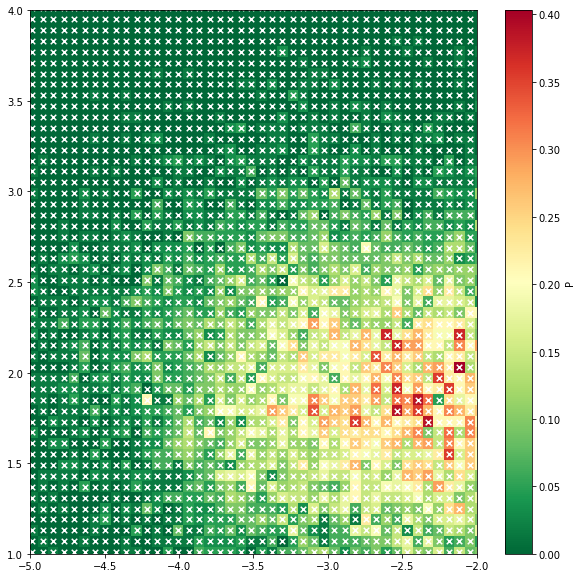

In [242]:
plt.figure(figsize=(10,10))
plt.hist2d(w0[:,0],w0[:,1], bins=100, density=True, range=[[-6,1],[-1,5]], cmap='RdYlGn_r')
plt.colorbar(label='P')
plt.scatter(W0,W1,marker="x" , s=30, color='white')
# plt.xticks(x_edge)
# plt.yticks(y_edge)
plt.xlim([-5,-2])
plt.ylim([1,4])
# plt.grid(which='major', linestyle='--')
plt.show()

In [199]:
W0, W1 = np.meshgrid(W0,W1)

In [176]:
W = np.moveaxis(np.stack((W0,W1)),0,-1)

In [177]:
PHII = W@phii.T

In [178]:
phii

array([[-0.6,  1. ],
       [ 0.6,  1. ]])

In [179]:
PHII.shape

(100, 100, 2)

In [180]:
t0=np.linspace(-5,10,1000)

In [181]:
t0.shape

(1000,)

In [182]:
t0[:, np.newaxis, np.newaxis, np.newaxis].shape

(1000, 1, 1, 1)

In [183]:
PHII[np.newaxis,:].shape

(1, 100, 100, 2)

In [186]:
prob_N = np.moveaxis(stats.norm.pdf(t0[:, np.newaxis, np.newaxis, np.newaxis], loc=PHII[np.newaxis,:], scale=1/np.sqrt(beta)),-1,0)

In [187]:
prob_N.shape

(2, 1000, 100, 100)

In [188]:
hist.shape

(100, 100)

In [189]:
integrand = prob_N*hist.T

In [190]:
integrand.shape

(2, 1000, 100, 100)

In [191]:
prob_t = np.sum(integrand, axis=(-1,-2))

In [192]:
prob_t.shape

(2, 1000)

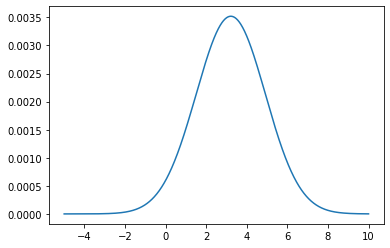

In [193]:
plt.plot(t0, prob_t[0,:]/np.sum(prob_t[0,:]))
plt.show()

In [154]:
t0[np.argmax(prob_t, axis=-1)]

array([3.21321321, 0.42042042])

In [169]:
EV = np.sum(t0*prob_t, axis=-1)/np.sum(prob_t, axis=-1)
print("Expectation value:", EV)
print("Variance:", np.sum((t0[:,np.newaxis]-EV).T**2*prob_t, axis=-1)/np.sum(prob_t, axis=-1))

Expectation value: [3.20053569 0.4194391 ]
Variance: [2.89614356 2.59853897]


In [170]:
phii@m1

array([3.18154423, 0.4603303 ])

In [171]:
1/beta+np.diagonal(phii@S1@(phii.T))

array([2.98449768, 2.6512828 ])